In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from numpy import genfromtxt
import os

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 

In [2]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE(sampling_strategy='minority')
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

In [3]:
def print_statistics(y_test, y_pred, i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    #print('test',tn, fp, fn, tp)
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))



In [7]:

def train_pred_SVM(X, y, features_filtered, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=None)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    
    X,y = balance_data(X,y)

    
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train1, y_train1 = balance_data(X_train.iloc[train], y_train[train])
        X_train1, y_train1 = X.iloc[train], y[train]
    
        X_test, y_test = X.iloc[test], y[test]
        X_train1 = X_train1[features_filtered.columns]
        X_test = X_test[features_filtered.columns]

        class_model = SVC(probability=True).fit(X_train1, y_train1)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        #print('gmeans',gmeans)
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
    print('classification_report')    
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./", "svm_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs



In [8]:
df = pd.read_csv('yourpath/three_dataset.csv', sep=",",index_col=None)
df2 = pd.read_csv('yourpath/training_dataset.csv', sep=",",index_col=None)

In [9]:
y = genfromtxt('yourpath/three_dataset_label.csv', encoding = 'utf-8',delimiter=',', invalid_raise = False)
y = np.nan_to_num(y)
y2 = genfromtxt('yourpath/training_dataset_label.csv', encoding = 'utf-8',delimiter=',', invalid_raise = False)
y2 = np.nan_to_num(y2)

In [15]:
from tsfresh import extract_features
extracted_features = extract_features(df, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


In [16]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y)

/Users/mhuan98/miniconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['ABR__kurtosis' 'ABR__sample_entropy' 'ABR__autocorrelation__lag_3' ...
 'ZNF770__permutation_entropy__dimension_7__tau_1'
 'ZNF770__query_similarity_count__query_None__threshold_0.0'
 'ZNF770__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [17]:
from tsfresh import extract_features
extracted_features2 = extract_features(df2, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


In [18]:
impute(extracted_features2)
features_filtered2 = select_features(extracted_features2, y2)

/Users/mhuan98/miniconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['ABR__kurtosis' 'ABR__sample_entropy' 'ABR__autocorrelation__lag_3' ...
 'ZNF770__permutation_entropy__dimension_7__tau_1'
 'ZNF770__query_similarity_count__query_None__threshold_0.0'
 'ZNF770__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(


fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       


/Users/mhuan98/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mhuan98/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/mhuan98/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is de

  0  ,    0.5833     ,    0.9167     ,    0.7500     ,    0.6875     ,    0.7857     
  1  ,    0.9167     ,    0.8333     ,    0.8750     ,    0.9091     ,    0.8696     
  2  ,    0.8333     ,    0.9167     ,    0.8750     ,    0.8462     ,    0.8800     
  3  ,    0.9167     ,    0.9167     ,    0.9167     ,    0.9167     ,    0.9167     
  4  ,    0.9167     ,    0.8333     ,    0.8750     ,    0.9091     ,    0.8696     
classification_report
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85        60
         1.0       0.84      0.88      0.86        60

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



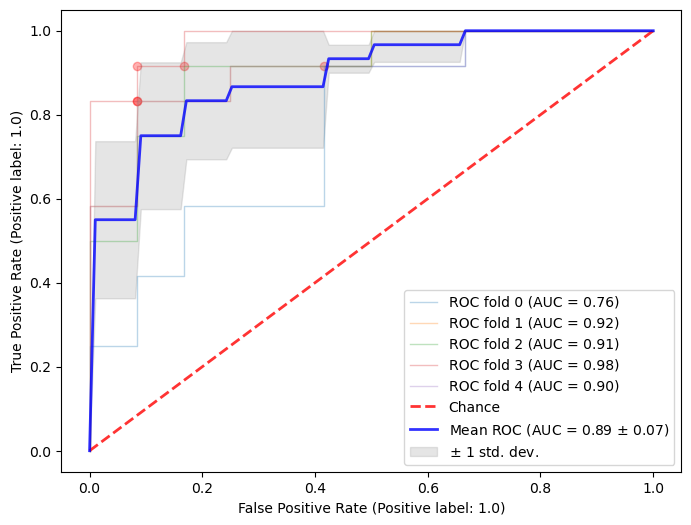

[0.7638888888888888, 0.9166666666666667, 0.9097222222222223, 0.9791666666666667, 0.9027777777777779]
0.8944444444444445


In [33]:
aucs1 = train_pred_SVM(extracted_features, y, features_filtered2,save=True)
print(aucs1)
print(np.mean(aucs1))